In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from IPython.display import display
import seaborn as sns
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import accuracy_score

# Персонализированные предложения  для постоянных клиентов интернет-магазина «В один клик»


## Введение

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


## План работы

**Задача: Прогнозирование уровня финансовой активности постоянных покупателей**

Необходимо:

1. **Промаркировать уровень финансовой активности клиентов**, выделив два уровня:
   - **«Снизилась»**, если клиент стал покупать меньше товаров.
   - **«Прежний уровень»**.

2. **Собрать данные по клиентам** по следующим группам признаков:
   - **Коммуникация с клиентом**: характеристики взаимодействия сотрудников компании с клиентом.
   - **Продуктовое поведение**: информация о покупаемых товарах и частоте покупок.
   - **Покупательское поведение**: данные о тратах клиента в магазине.
   - **Поведение на сайте**: данные о просмотре страниц и времени, проведённом на сайте.

3. **Визуализировать группы признаков** (вместе с целевым признаком) в виде диаграммы Исикавы. На диаграмме входные признаки объединены в четыре группы:
   - Коммуникация с клиентом.
   - Продуктовое поведение.
   - Поведение на сайте.
   - Финансовое поведение.



Цель: построить модель, которая **предскажет вероятность снижения покупательской активности клиента** в следующие три месяца.


- В исследование должны быть включены **данные финансового департамента** о прибыльности клиента:
  - Доход, который каждый покупатель приносил компании за последние три месяца.

- На основе данных модели и финансовой прибыльности клиентов:
  1. Выделить **сегменты покупателей**.
  2. Разработать **персонализированные предложения** для каждого сегмента.


## Шаг 1. Загрузка данных

In [2]:
df_market = pd.read_csv('market_file.csv', index_col='id')
df_money = pd.read_csv('market_money.csv', index_col='id')
df_time_spend = pd.read_csv('market_time.csv', index_col='id')
df_income = pd.read_csv('money.csv', sep=';', index_col='id', decimal = ',')
datasets = [df_market, df_money, df_time_spend, df_income]
datasets_str = ['df_market', 'df_money', 'df_time_spend', 'df_income']

Создадим функцbю для более подробного изучения первчиной информации

In [3]:
def data_info(dataset):
    
    print("Первые строки датафрейма")
    display(dataset.head())
    print('\n\nПервичная информация')
    dataset.info()
    print('-' * 50)
    print('\n\n')

In [4]:
for dataset in datasets:
    data_info(dataset)

Первые строки датафрейма


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Период   3900 non-null   object 
 1   Выручка  3900 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB
--------------------------------------------------



Первые строки датафрейма


,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдцщий_месяц,13
215349,текущий_месяц,10
215349,предыдцщий_месяц,12
215350,текущий_месяц,13




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB
--------------------------------------------------



Первые строки датафрейма


,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB
--------------------------------------------------





### Вывод

Данные в таблицах соответствуют описанию

Заметим, что в данных нет пропусков

Столбцы датафреймов не соответствуют стандартам и требуют переименования

В неккоторых данных присутствуют ошибки при заполнении

## Шаг 2. Предобработка данных

In [5]:
# Меняем регистр столбцов датафреймов на нижний
for dataset in datasets:
    dataset.columns = dataset.columns.str.lower()

In [6]:
# Проверим данные на неявные дубликаты и проверим присутствующие значения в столбцах


for i, dataset in enumerate(datasets):
    string_columns = dataset.select_dtypes(include='object')
    for col in string_columns:
        print(f'{datasets_str[i]}, column "{col}"')
        print(dataset[col].unique())
        print('_________________________________')


df_market, column "покупательская активность"
['Снизилась' 'Прежний уровень']
_________________________________
df_market, column "тип сервиса"
['премиум' 'стандартт' 'стандарт']
_________________________________
df_market, column "разрешить сообщать"
['да' 'нет']
_________________________________
df_market, column "популярная_категория"
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
_________________________________
df_money, column "период"
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
_________________________________
df_time_spend, column "период"
['текущий_месяц' 'предыдцщий_месяц']
_________________________________


In [7]:
# Приведем данные к нужному виду
df_market.loc[df_market['тип сервиса'] == 'стандартт', 'тип сервиса'] = 'стандарт'
df_time_spend.loc[df_time_spend["период"] == 'предыдцщий_месяц', "период"] = 'предыдущий_месяц'
for dataset in datasets:
    string_columns = dataset.select_dtypes(include='object')
    for col in string_columns:
        for value in dataset[col].unique():
            dataset.loc[dataset[col] == value, col] = value.lower().replace(" ", "_")

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [8]:
for i, dataset in enumerate(datasets):
    string_columns = dataset.select_dtypes(include='object')
    for col in string_columns:
        print(f'{datasets_str[i]}, column "{col}"')
        print(dataset[col].unique())
        print('_________________________________')

df_market, column "покупательская активность"
['снизилась' 'прежний_уровень']
_________________________________
df_market, column "тип сервиса"
['премиум' 'стандарт']
_________________________________
df_market, column "разрешить сообщать"
['да' 'нет']
_________________________________
df_market, column "популярная_категория"
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']
_________________________________
df_money, column "период"
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
_________________________________
df_time_spend, column "период"
['текущий_месяц' 'предыдущий_месяц']
_________________________________


In [9]:
df_market.reset_index(drop=False, inplace = True)
df_time_spend.reset_index(drop=False, inplace = True)
df_money.reset_index(drop=False, inplace = True)
df_income.reset_index(drop=False, inplace = True)

In [10]:
# Проверим данные на явные дубликаты

for i, dataset in enumerate(datasets):
    print(f"{datasets_str[i]}: {dataset.duplicated().sum()}")


df_market: 0
df_money: 0
df_time_spend: 0
df_income: 0


Удалим их

In [11]:
df_market.drop_duplicates(keep='first', inplace = True)
df_money.drop_duplicates(keep='first', inplace = True)
df_time_spend.drop_duplicates(keep='first', inplace = True)
df_income.drop_duplicates(keep='first', inplace = True)

In [12]:
for i, dataset in enumerate(datasets):
    print(f"{datasets_str[i]}: {dataset.duplicated().sum()}")

df_market: 0
df_money: 0
df_time_spend: 0
df_income: 0


In [13]:
df_market.set_index('id', inplace=True)
df_money.set_index('id', inplace=True)
df_time_spend.set_index('id', inplace=True)
df_income.set_index('id', inplace=True)

In [14]:
for i, dataset in enumerate(datasets):
    print(datasets_str[i])
    data_info(dataset)

df_market
Первые строки датафрейма


,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,
215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская активность            1300 non-null   object 
 1   тип сервиса                          1300 non-null   object 
 2   разрешить сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  

,период,выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   период   3900 non-null   object 
 1   выручка  3900 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB
--------------------------------------------------



df_time_spend
Первые строки датафрейма


,период,минут
id,,
215348,текущий_месяц,14
215348,предыдущий_месяц,13
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB
--------------------------------------------------



df_income
Первые строки датафрейма


,прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21




Первичная информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB
--------------------------------------------------





### Вывод

Выполнена преобработка данных 

Исправлены ошибки в заполнении данных и данные приведены к нужному виду

Дубликаты удалены

## Шаг 3. Исследовательский анализ данных

### Отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

### Статистический анализ данных

df_market маркет_актив_6_мес
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


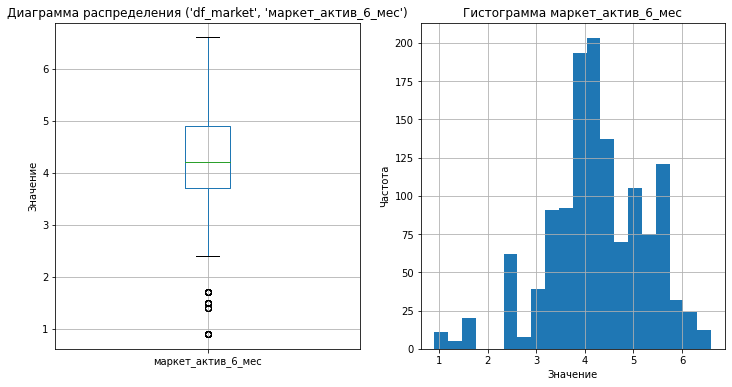


-------------------
df_market маркет_актив_тек_мес
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


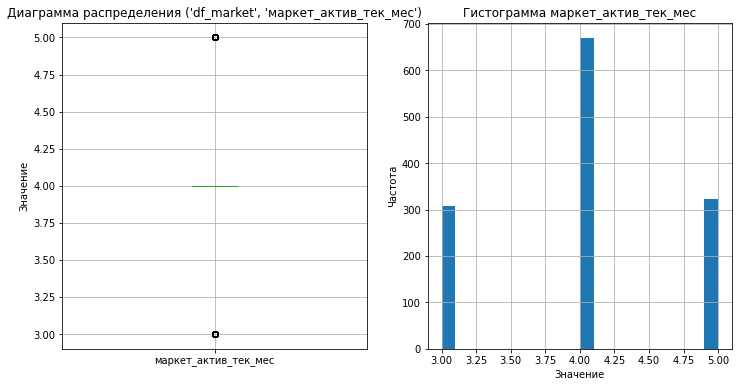


-------------------
df_market длительность
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


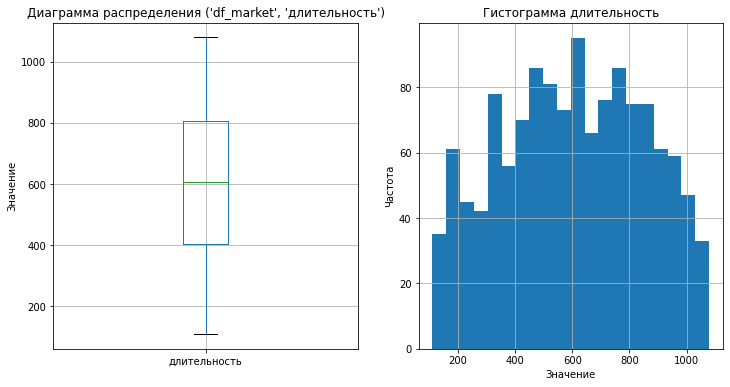


-------------------
df_market акционные_покупки
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


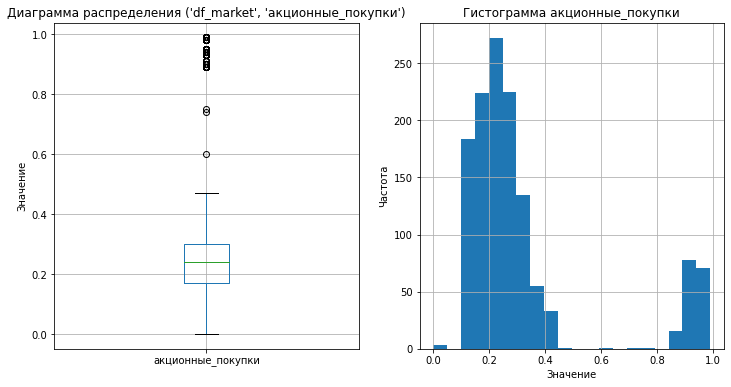


-------------------
df_market средний_просмотр_категорий_за_визит
count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


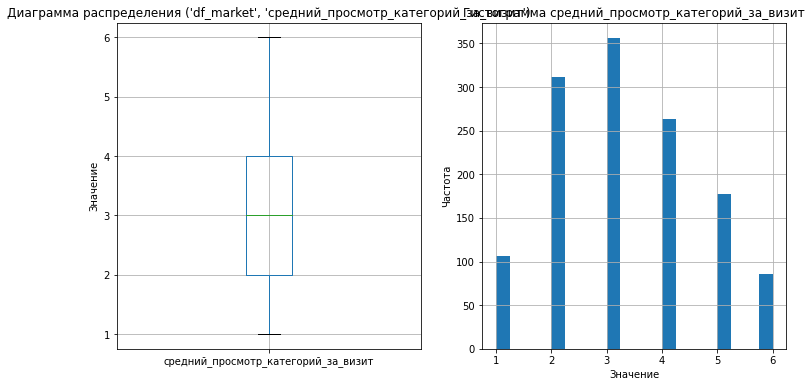


-------------------
df_market неоплаченные_продукты_штук_квартал
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


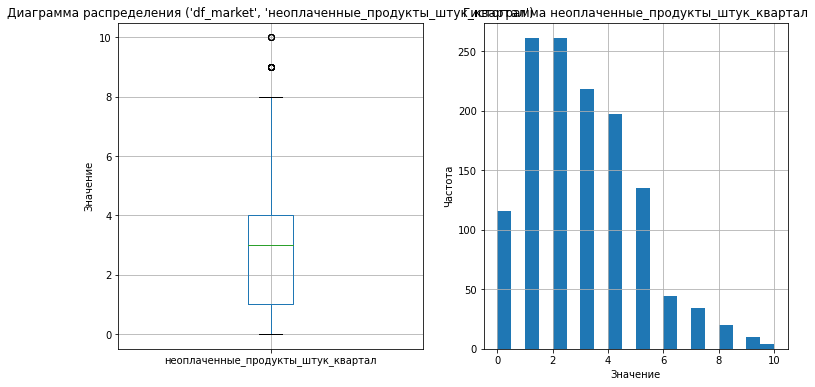


-------------------
df_market ошибка_сервиса
count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


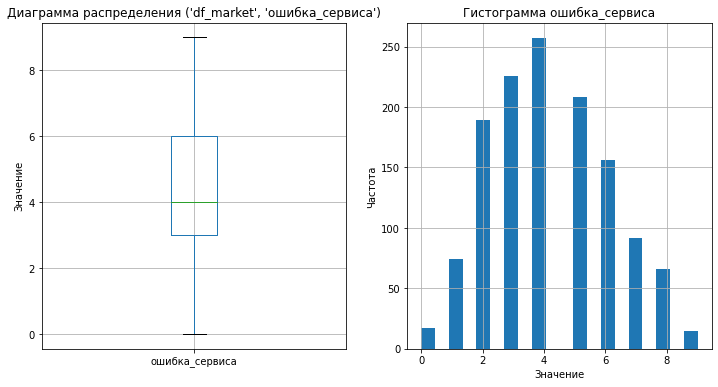


-------------------
df_market страниц_за_визит
count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


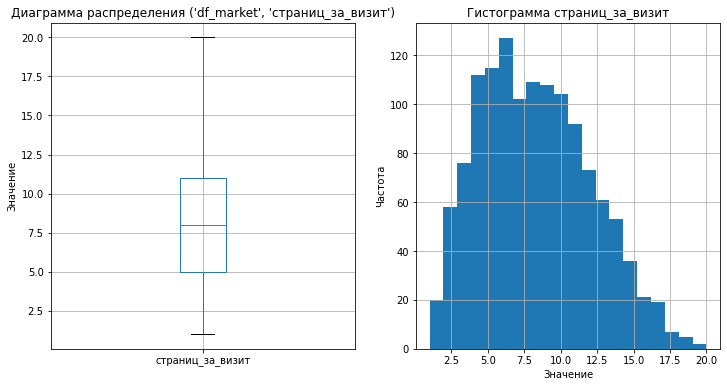


-------------------
Частотное распределение для ('df_market', 'покупательская активность'):
прежний_уровень    802
снизилась          498
Name: покупательская активность, dtype: int64

Процентное соотношение:
прежний_уровень    61.692308
снизилась          38.307692
Name: покупательская активность, dtype: float64


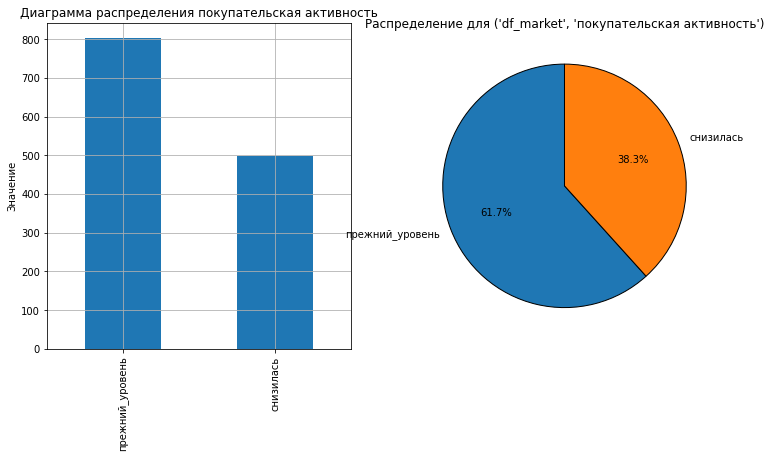


-------------------
Частотное распределение для ('df_market', 'тип сервиса'):
стандарт    924
премиум     376
Name: тип сервиса, dtype: int64

Процентное соотношение:
стандарт    71.076923
премиум     28.923077
Name: тип сервиса, dtype: float64


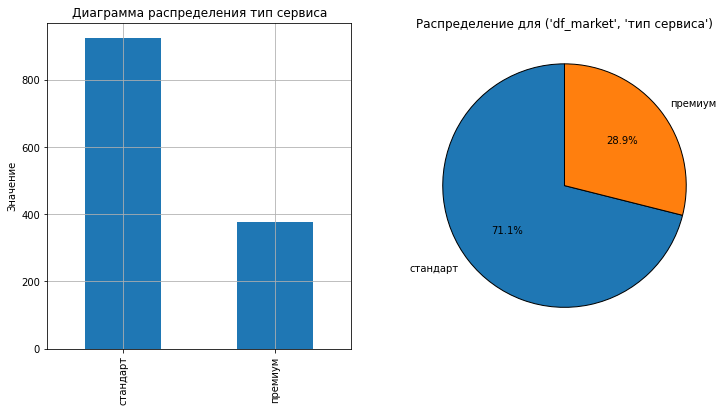


-------------------
Частотное распределение для ('df_market', 'разрешить сообщать'):
да     962
нет    338
Name: разрешить сообщать, dtype: int64

Процентное соотношение:
да     74.0
нет    26.0
Name: разрешить сообщать, dtype: float64


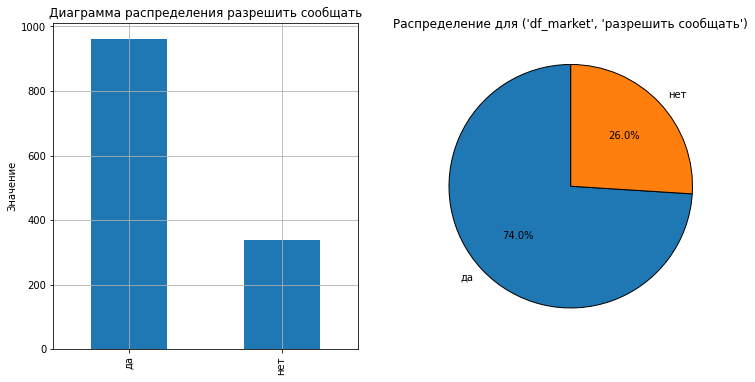


-------------------
Частотное распределение для ('df_market', 'популярная_категория'):
товары_для_детей                        330
домашний_текстиль                       251
косметика_и_аксесуары                   223
техника_для_красоты_и_здоровья          184
мелкая_бытовая_техника_и_электроника    174
кухонная_посуда                         138
Name: популярная_категория, dtype: int64

Процентное соотношение:
товары_для_детей                        25.384615
домашний_текстиль                       19.307692
косметика_и_аксесуары                   17.153846
техника_для_красоты_и_здоровья          14.153846
мелкая_бытовая_техника_и_электроника    13.384615
кухонная_посуда                         10.615385
Name: популярная_категория, dtype: float64


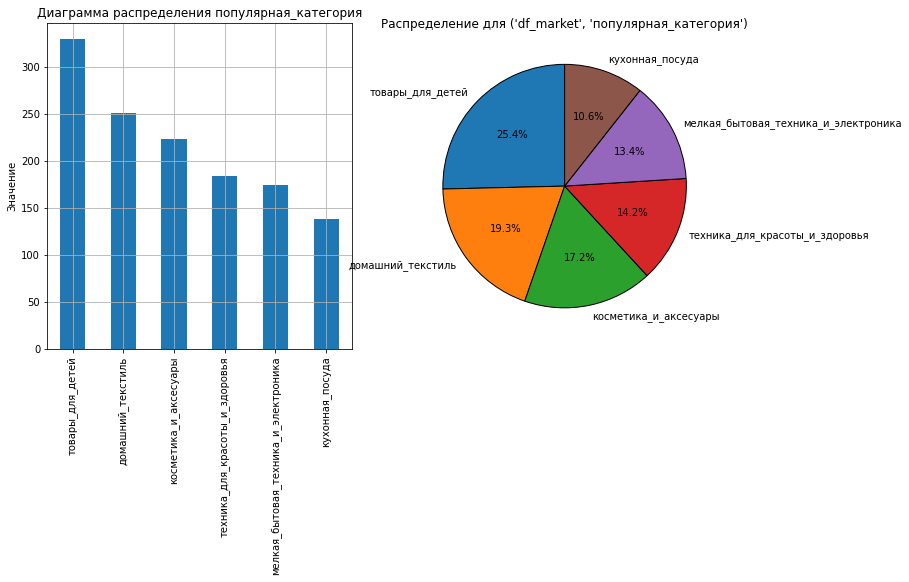


-------------------
df_money выручка
count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64


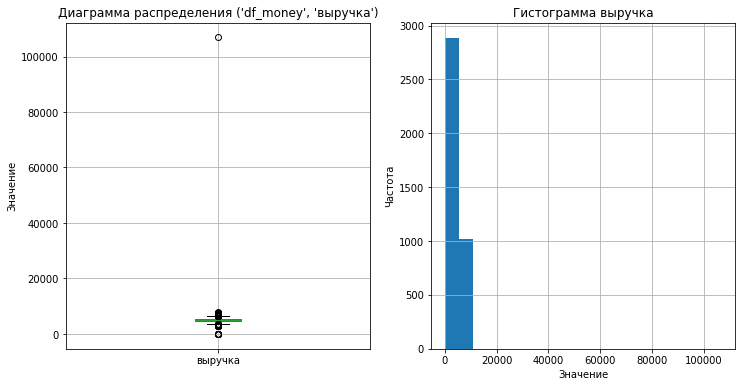


-------------------
Частотное распределение для ('df_money', 'период'):
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64

Процентное соотношение:
препредыдущий_месяц    33.333333
текущий_месяц          33.333333
предыдущий_месяц       33.333333
Name: период, dtype: float64


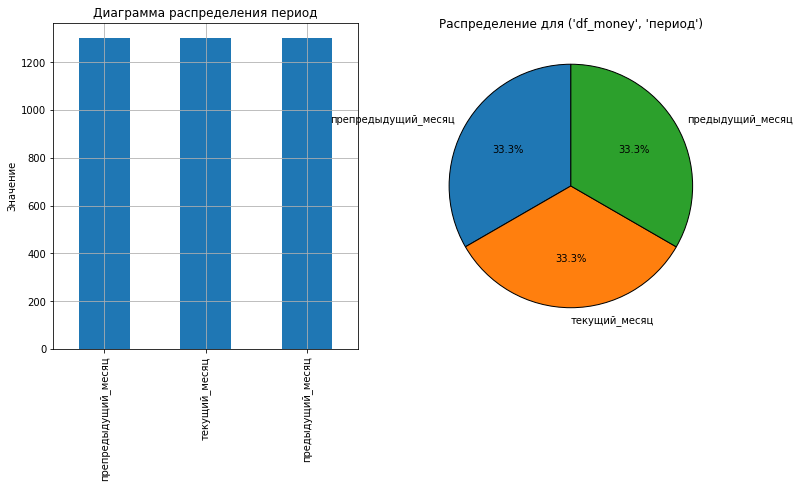


-------------------
df_time_spend минут
count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


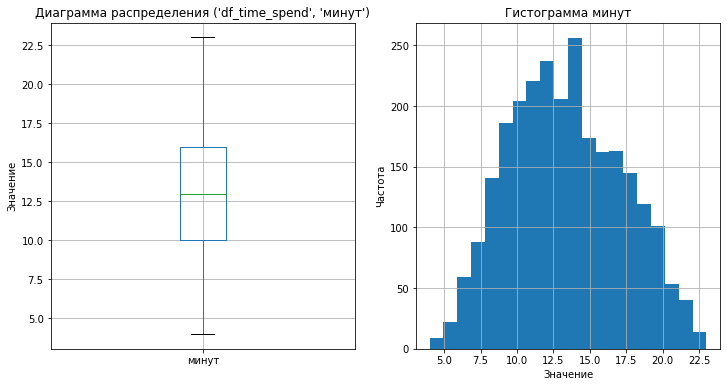


-------------------
Частотное распределение для ('df_time_spend', 'период'):
текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64

Процентное соотношение:
текущий_месяц       50.0
предыдущий_месяц    50.0
Name: период, dtype: float64


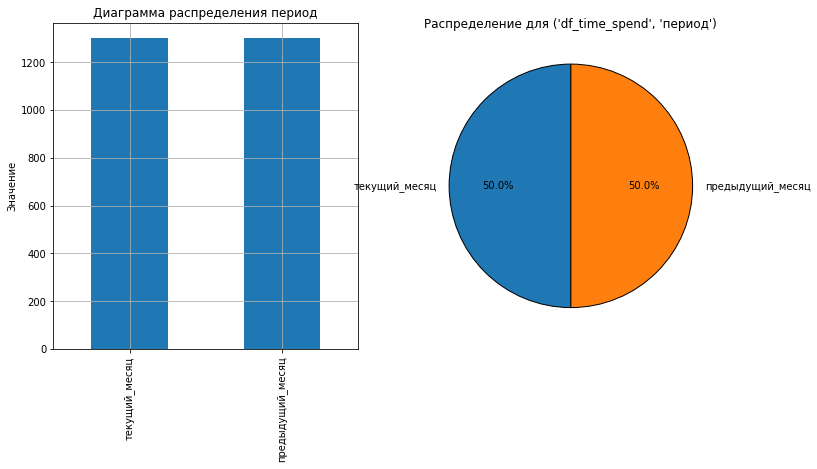


-------------------
df_income прибыль
count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


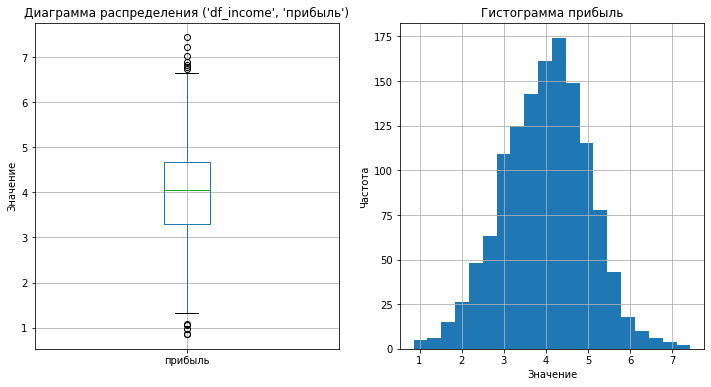


-------------------


In [15]:

for i, dataset in enumerate(datasets):
    string_columns = dataset.select_dtypes(include='object')
    num_columns = dataset.select_dtypes(include=['int64', 'float64'])
    for col in num_columns:
        print(datasets_str[i], col)
        print(dataset[col].describe())
        
        # Визуализируем
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        dataset[col].plot.box(ax=axes[0])
        axes[0].set_title(f'Диаграмма распределения {datasets_str[i], col}')
        axes[0].grid(True)
        axes[0].set_ylabel('Значение')
        dataset[col].plot.hist(bins=20, ax=axes[1])
        axes[1].set_title(f'Гистограмма {col}')
        axes[1].grid(True)
        axes[1].set_ylabel('Частота')
        axes[1].set_xlabel('Значение')
        plt.suptitle('')  # Убираем общий заголовок
        plt.show()
        print("\n-------------------")
        
    for col in string_columns:
        print(f"Частотное распределение для {datasets_str[i], col}:")
        print(dataset[col].value_counts())
        print("\nПроцентное соотношение:")
        print(dataset[col].value_counts(normalize=True) * 100)

        # Визуализация распределения
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        dataset[col].value_counts().plot.bar(ax=axes[0])
        axes[0].set_title(f'Диаграмма распределения {col}')
        axes[0].grid(True)
        axes[0].set_ylabel('Значение')
        axes[0].tick_params(axis='x', rotation=90)
        dataset[col].value_counts().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1}
        )
        plt.title(f'Распределение для {datasets_str[i], col}')
        plt.ylabel('')
        plt.show()

        print("\n-------------------")      

In [16]:
df_money.head()

,период,выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


### Удаление выбросов

In [17]:
# Удаление выброса из столбца выручки
df_money = df_money[df_money['выручка'] < 100000]
print(df_money['выручка'].describe())

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64


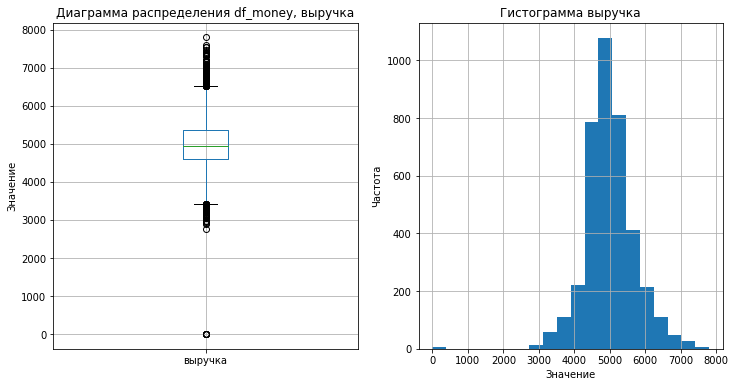


-------------------


In [18]:

# Визуализируем
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df_money['выручка'].plot.box(ax=axes[0])
axes[0].set_title(f'Диаграмма распределения {datasets_str[1]}, выручка')
axes[0].grid(True)
axes[0].set_ylabel('Значение')
df_money['выручка'].plot.hist(bins=20, ax=axes[1])
axes[1].set_title(f'Гистограмма выручка')
axes[1].grid(True)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Значение')
plt.suptitle('')  # Убираем общий заголовок
plt.show()
print("\n-------------------")

### Отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

Это значит что в датафрейме `df_money` за препредыдущий месяц, предыдущий месяц и текцщий месяц выручка должна быть больше 0

In [19]:
df_money['is_active'] = df_money['выручка'].apply(lambda val: 1 if val > 0 else 0)
df_money.head()

/tmp/ipykernel_782/3416482882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_money['is_active'] = df_money['выручка'].apply(lambda val: 1 if val > 0 else 0)


,период,выручка,is_active
id,,,
215348,препредыдущий_месяц,0.0,0
215348,текущий_месяц,3293.1,1
215348,предыдущий_месяц,0.0,0
215349,препредыдущий_месяц,4472.0,1
215349,текущий_месяц,4971.6,1


In [20]:
active_users = df_money.groupby('id').sum()
active_users = active_users[active_users['is_active']>=3].index.to_list()
len(active_users)

1296

In [21]:
df_money = df_money[df_money.index.isin(active_users)]
df_money.head()

,период,выручка,is_active
id,,,
215349,препредыдущий_месяц,4472.0,1
215349,текущий_месяц,4971.6,1
215349,предыдущий_месяц,5216.0,1
215350,препредыдущий_месяц,4826.0,1
215350,текущий_месяц,5058.4,1


### Вывод

###### + Почти все данные распоожены внутри "усов", но иногда встречаются более редкие значения, котроые выбиваются из всех остальных

+ В датасете `df_market` `маркет_актив_6_мес` и `акционные_покупки` имеют скошенное распределение. 
Это указывает на вероятное наличие перекосов в данных. 
Скорее всего в данных существую подгруппы или данные зависят от категориальных призанков

+ `маркет_актив_тек_мес` можно рассматривать как категориальрную переменную т.к. столюец имеет всего 3 значения

+ В данных о выручке есть выброс, который должен быть удален

+ В данных `покупательская активность`, `разрешить сообщать` и `тип сервиса` имеет значительный дисбаланс классов

+ Выдеелны 693 активных покупателей за текущий период

## Шаг 4. Объединение таблиц

### Обьединяем `df_market` и `df_time_spend`

In [22]:
df_time_spend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


In [23]:
display(df_time_spend.head())
df_time_spend_pivot = df_time_spend.pivot(columns='период', values='минут')
df_time_spend_pivot.columns.name = None
df_time_spend_pivot.columns = ['время_предыдущий_месяц', 'время_текущий_месяц']
df_time_spend_pivot.head()

,период,минут
id,,
215348,текущий_месяц,14
215348,предыдущий_месяц,13
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13


,время_предыдущий_месяц,время_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [24]:
df_time_spend_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   время_предыдущий_месяц  1300 non-null   int64
 1   время_текущий_месяц     1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


In [25]:
data_market = pd.merge(df_market, df_time_spend_pivot, on='id', how='left')
data_market.head()

,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,13,14
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,8,11


In [26]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская активность            1300 non-null   object 
 1   тип сервиса                          1300 non-null   object 
 2   разрешить сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Верно, при объединении таблиц нужно привязаться к уникальному `"id"`.</font>

### Создаем итоговую таблицу 

In [27]:
display(df_money.head())
df_money_pivot = df_money.pivot(columns='период', values='выручка')
df_money_pivot.columns.name = None
df_money_pivot.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
df_money_pivot.head()

,период,выручка,is_active
id,,,
215349,препредыдущий_месяц,4472.0,1
215349,текущий_месяц,4971.6,1
215349,предыдущий_месяц,5216.0,1
215350,препредыдущий_месяц,4826.0,1
215350,текущий_месяц,5058.4,1


,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [28]:
data_market = pd.merge(data_market, df_money_pivot, on='id', how='right')
data_market.head()

,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


In [29]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская активность            1296 non-null   object 
 1   тип сервиса                          1296 non-null   object 
 2   разрешить сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

### Вывод

Обьеднили таблицы и оставили данные только для клиентов с покупательской активностью не менее трёх месяцев

## Шаг 5. Корреляционный анализ

In [30]:
!pip install phik

In [31]:
from phik.report import plot_correlation_matrix
from phik import report

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable выручка_предыдущий_месяц is large: 1120. Are you sure this is not an interval variable? Analysis for pairs of variables including выручка_предыдущий_месяц can be slow.
  warnings.warn(


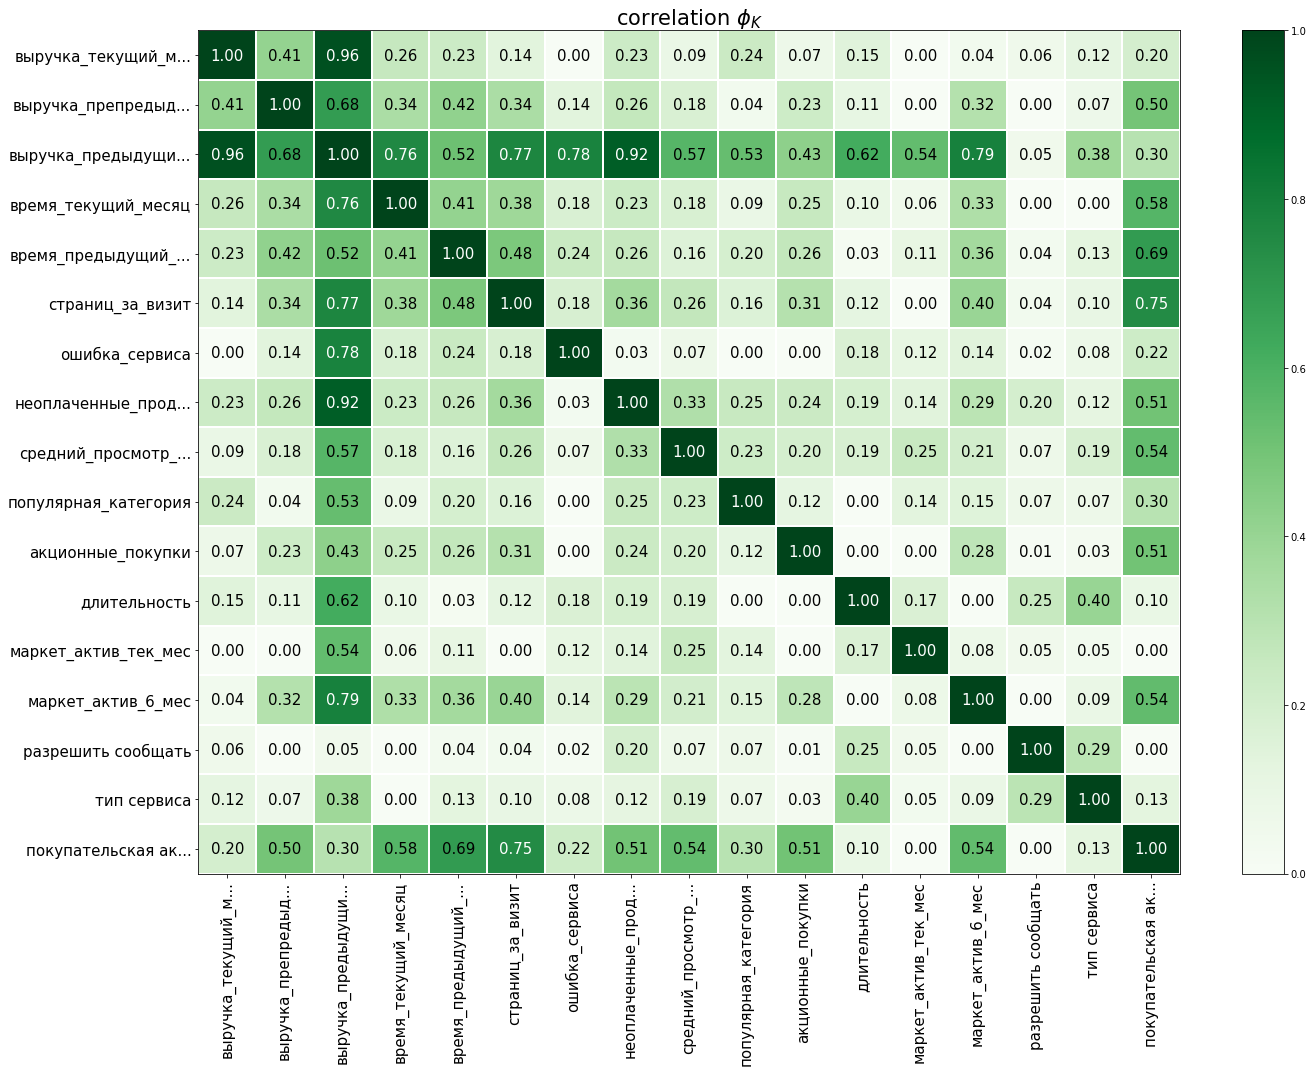

In [32]:
interval_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
    'страниц_за_визит', 'время_предыдущий_месяц', 'время_текущий_месяц',
    'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'
]
phik_overview = data_market.phik_matrix(interval_cols=interval_cols)

# Визуализация корреляционной матрицы
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

## Шаг 6. Использование пайплайнов

In [33]:
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

In [34]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop('покупательская активность', axis=1),
    data_market['покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_market['покупательская активность'])

In [35]:
#закодируем целевой признак
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test) 
label_encoder.classes_

array(['прежний_уровень', 'снизилась'], dtype=object)

In [36]:
class_mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
print(class_mapping)

{'прежний_уровень': 0, 'снизилась': 1}


In [37]:
# создаём списки с названиями признаков
ohe_columns = [ 
    'тип сервиса', 
    'разрешить сообщать', 
    'популярная_категория', 
    'ошибка_сервиса'
]
num_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'страниц_за_визит', 
    'время_предыдущий_месяц', 
    'время_текущий_месяц',  
    'выручка_препредыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц'
]

In [38]:
# создаём пайплайн для подготовки признаков из списка ohe_columns OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [39]:
# создаём пайплайн для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', MinMaxScaler())
])

In [40]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [41]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [42]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__ohe': [OneHotEncoder(drop='first', sparse=False)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        # указываем список методов масштабирования
        'preprocessor__ohe': [OneHotEncoder(drop='first', sparse=False)
                             ],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 7),
        'preprocessor__ohe': [OneHotEncoder(drop='first', sparse=False),
                             ],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability= True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'sigmoid'],
        'preprocessor__ohe': [OneHotEncoder(drop='first', sparse=False),
                             ],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=6,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter = 25
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=6,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=Fals

In [44]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['тип сервиса',
                                                   'разрешить сообщать',
                                                   'популярная_категория',
                                                   'ошибка_сервиса']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
              

Т.к у нас есть значимый дисбаланс классов, то нам важно выбрать метрику, которая не зависит от частоты классов и оценивает производительность модели по отношению ко всем классам именно поэтому вы выбираем `ROC_AUC`

Посмотрим значение метрики на тестовой выборке

In [45]:
model = randomized_search.best_estimator_
y_proba = model.predict_proba(X_test)[:, 1]
print(f"roc_auc = {roc_auc_score(y_test, y_proba)}")

roc_auc = 0.9159487117259232


In [1]:
y_proba

NameError: name 'y_proba' is not defined

### Вывод

+ Луйчшей моделью оказалосась `LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')`с кодировкой категориальный переменных пр помощи `OneHotEncoder` и `StandardScaler()`
 
+ roc_auc = 0.915341989240788

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

## Шаг 7. Анализ важности признаков

In [47]:
!pip install shap 

In [48]:
import shap

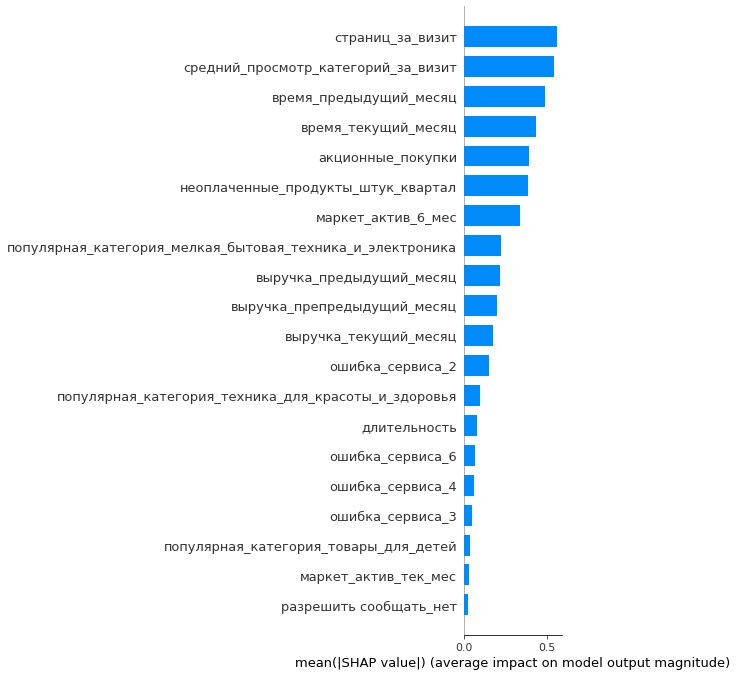

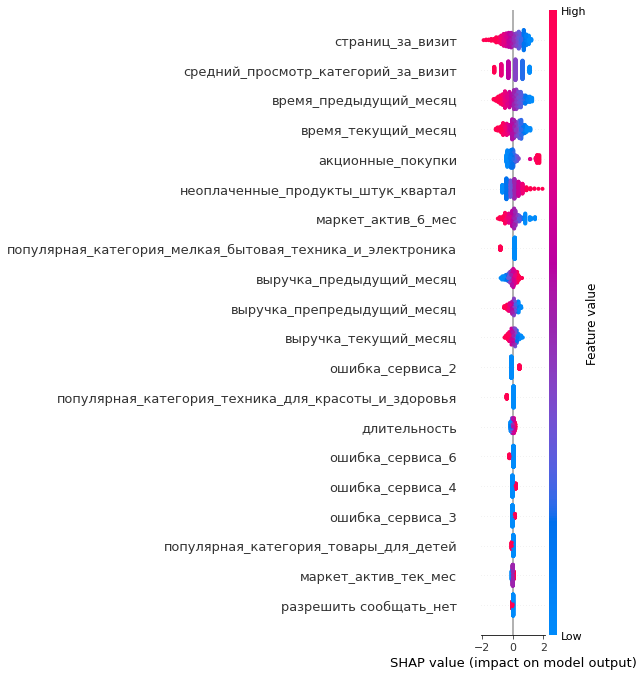

In [49]:
# Применяем препроцессор к данным
X_train_preprocessed = model.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = model.named_steps['preprocessor'].transform(X_test)


explainer = shap.LinearExplainer(model.named_steps['models'], X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names(ohe_columns)
all_feature_names = list(ohe_feature_names) + num_columns

# Графики важности признаков
shap.summary_plot(shap_values, feature_names=all_feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=all_feature_names)


### Вывод

+ Признаки с самой высокой важностью, которые оказывают значительное влияние на целевой признак:
        + страниц_за_визит: Самый значимый признак, что говорит о сильной связи между количеством просмотренных страниц за визит и покупательской активностью
        + средний_просмотр_категорий_за_визит: Второй по значимости признак, показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца
        + время_предыдущий_месяц: Важный временной показатель, характеризующий активность пользователя в прошлом
        + неоплаченные_продукты_штук_квартал: Показывает связь между неоплаченными товарами и целевым признаком
        + время_текущий_месяц: Демонстрирует текущую активность пользователей
        + акционные_покупки: среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев
        + маркет_актив_6_мес: среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента
+ Признаки с самой низкой важностью, которые практически не влияют на целевой признак:
        + тип сервиса
        + выручка_текущий_месяц
        + разрешить сообщать
        + маркет_актив_тек_мес
        + длительность

**Использование наблюдений для бизнеса**

+ Повышение количества страниц, которые пользователи просматривают, может привести к росту покупательской активности
+ Маркетинговые усилия следует ориентировать на тех пользователей, которые проявляли активность в течении периода, продумать подход для проведения акций для таких пользователей
+ Разработка стратегии для уменьшения числа неоплаченных заказов поможет повысить общую покупательскую активность

## Шаг 8. Сегментация покупателей

In [50]:
# Предсказание вероятностей
probabilities = pd.DataFrame(
    model.predict_proba(data_market.drop('покупательская активность', axis=1))[:, 1],
    columns=['вероятность_снижения']
)

data_seg = pd.concat([data_market.reset_index(), probabilities.reset_index()], axis=1)
data_seg.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,index,вероятность_снижения
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,12,10,5216.0,4472.0,4971.6,0,0.925634
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4,1,0.307407
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,2,0.738205
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,8,11,5807.5,4594.0,5872.5,3,0.956009
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5,4,0.551563


### Обьединение таблиц

In [51]:
df_income.head()

,прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


In [52]:
data_seg.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,index,вероятность_снижения
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,12,10,5216.0,4472.0,4971.6,0,0.925634
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4,1,0.307407
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,2,0.738205
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,8,11,5807.5,4594.0,5872.5,3,0.956009
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5,4,0.551563


In [53]:
data_seg = pd.merge(data_seg, df_income, on='id', how = 'left')
data_seg.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,index,вероятность_снижения,прибыль
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,...,2,5,12,10,5216.0,4472.0,4971.6,0,0.925634,4.16
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,...,1,5,8,13,5457.5,4826.0,5058.4,1,0.307407,3.13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,...,6,4,11,13,6158.0,4793.0,6610.4,2,0.738205,4.87
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,...,3,2,8,11,5807.5,4594.0,5872.5,3,0.956009,4.21
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,...,1,4,10,10,4738.5,5124.0,5388.5,4,0.551563,3.95


### Отбор клиентов

Разделим клиентов на группы 

Группы покупателей:

1. Прежний уровень активности и высокая прибыльность

2. Прежний уровень активности и низкая прибыльность

3. Снижающаяся активность и высокая прибыльность

4. Снижающаяся активность и низкая прибыльность

**Рассмотрим группу 3: Снижающаяся активность и высокая прибыльность**

т.к снижение активности и покупок может привести к потере клиентов, способных принести наибольшую прибыль, а также такие клиенты имеют потенциал для увеличения покупательской активности и прибыли при минимальных вложениях

Отберем клиентов, прибыль которых больше 60% всех клиентов и покупательская активность которых снизилась

In [54]:
q60 = data_seg['прибыль'].quantile(0.6)

filtered_data = data_seg[
    (data_seg['прибыль'] > q60) & 
    (data_seg['вероятность_снижения'] >= 0.7)
]
filtered_data.drop('index', axis =1, inplace = True)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 2 to 1255
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   149 non-null    int64  
 1   покупательская активность            149 non-null    object 
 2   тип сервиса                          149 non-null    object 
 3   разрешить сообщать                   149 non-null    object 
 4   маркет_актив_6_мес                   149 non-null    float64
 5   маркет_актив_тек_мес                 149 non-null    int64  
 6   длительность                         149 non-null    int64  
 7   акционные_покупки                    149 non-null    float64
 8   популярная_категория                 149 non-null    object 
 9   средний_просмотр_категорий_за_визит  149 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   149 non-null    int64  
 11  ошибка_сервиса                 

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

In [55]:
data_seg = data_seg[~data_seg.index.isin(filtered_data.index)]

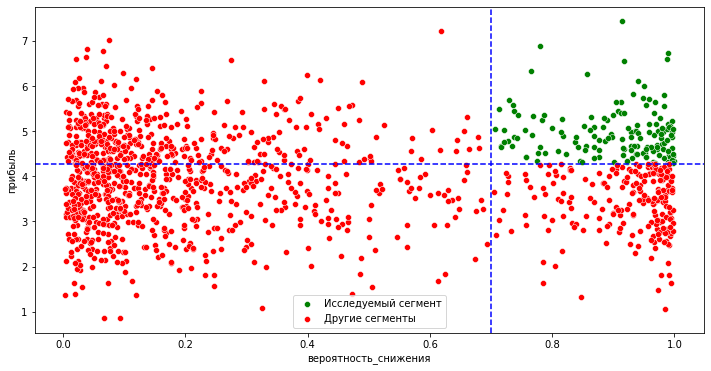

In [56]:
plt.figure(figsize = (12,6))
sns.scatterplot(data=filtered_data, x='вероятность_снижения', y='прибыль', label='Исследуемый сегмент', color='green')
sns.scatterplot(data=data_seg, x='вероятность_снижения', y='прибыль', label='Другие сегменты', color='red')
plt.legend()
plt.axvline(x=0.7, color='blue', linestyle='--')
plt.axhline(y=q60, color='blue', linestyle='--')
plt.show()


### Исследование отобранной группы

Для дополнительного исследования возьмем группу клиентов с наибольшим количеством акционных покупок т.к. для такой группы существует множество различных вариантов персонализации

In [57]:
q7 = filtered_data['акционные_покупки'].quantile(0.7)

# Отбор клиентов с наибольшим количеством акционных покупок
selected_group = filtered_data[filtered_data['акционные_покупки'] > q7]

# Остальные клиенты 
remaining_group = data_seg.loc[~data_seg.index.isin(filtered_data.index)]

In [58]:
columns_to_plot = [
    'страниц_за_визит',
    'средний_просмотр_категорий_за_визит',
    'время_предыдущий_месяц',
    'неоплаченные_продукты_штук_квартал',
    'время_текущий_месяц',
    'акционные_покупки',
    'маркет_актив_6_мес'
]

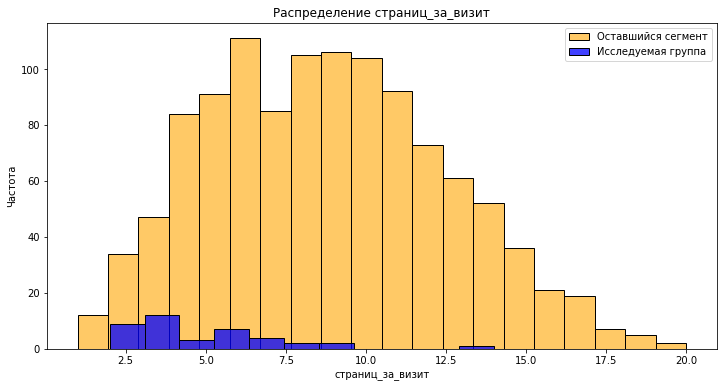

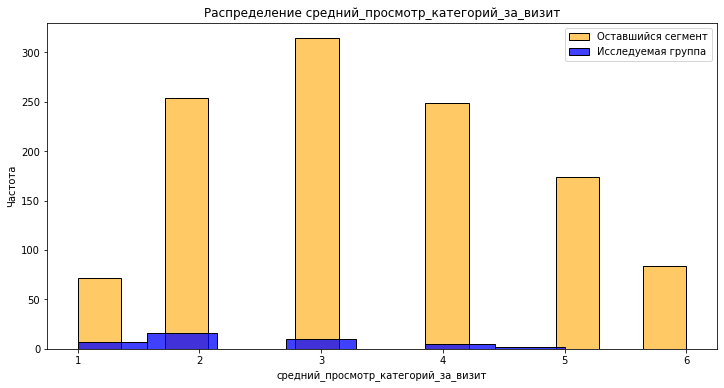

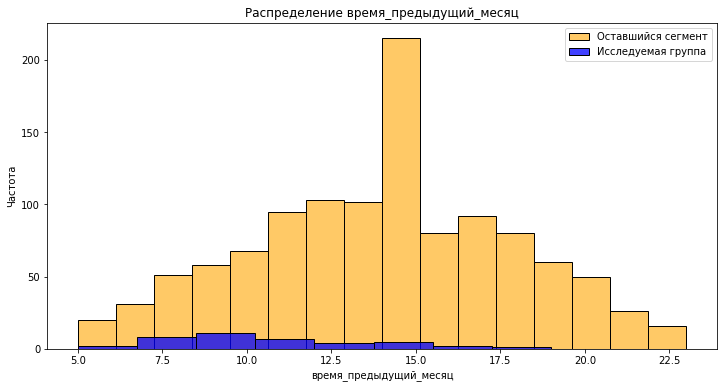

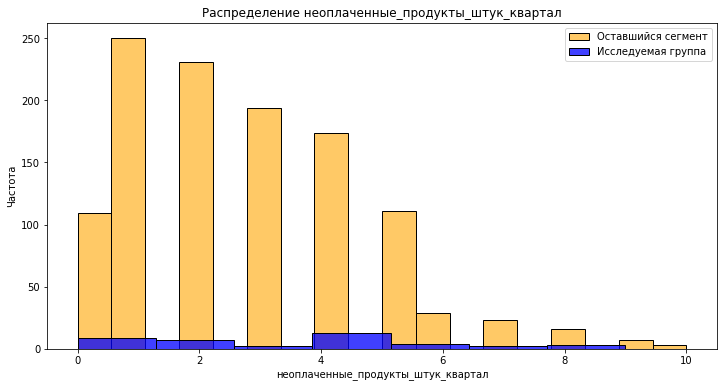

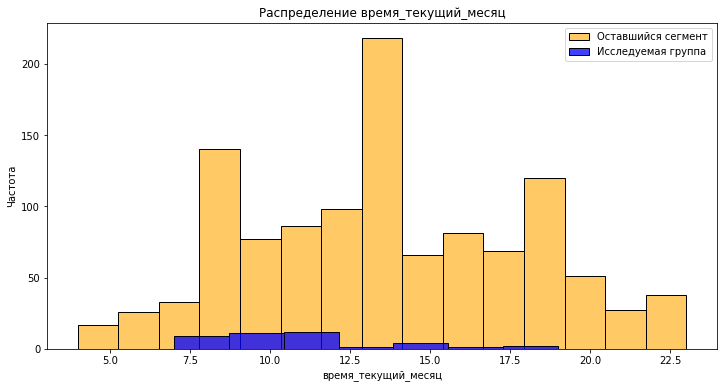

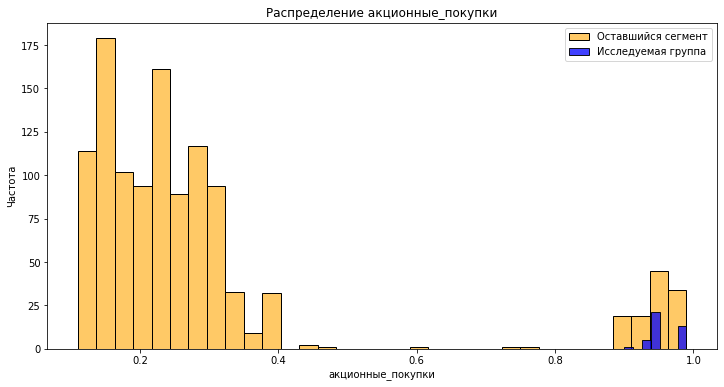

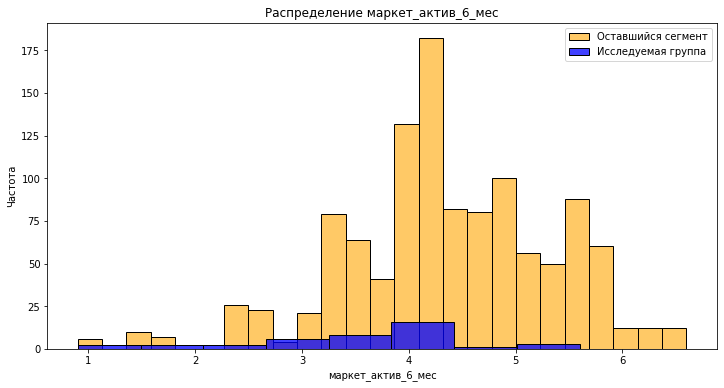

In [59]:
for col in columns_to_plot:
    plt.figure(figsize=(12, 6))
    sns.histplot(remaining_group[col], label='Оставшийся сегмент', color='orange', alpha=0.6)
    sns.histplot(selected_group[col], label='Исследуемая группа', color='blue')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.legend()
    plt.show()

Основные характеристики:
+ `страниц_за_визит`: исследуемая группа посещает меньше страниц чем остальные, скорее всего это связано с тем, что клиенты просматривают только акционные товары

+ `время`: Исследуемой группы тратит заметно меньше времени на просмотр товаров, что может быть связано с низким количеством акций. или отсутсвием акций на нужные товары

+ `неоплаченные_продукты`: Заметим, что исследуемая группа оставляет неоплаченные дродукты в корзине, что может быть связано с тем, что акции и скидки закончились или их вообще и не было

+ `маркет_актив_6_мес`: по маркетинговой активности можем увидеть, что исследуемая группа мало участвует в маркетинговый событиях, это может быть связано с тем , что клиенты мало заинтересованы в маркетинговый активностях без наград в виде скидочных купонов или персонализированных предложений

### Предложения по работе с сегментом

+ Увеличить количество акционных товаров или предложений на основе истории просмотров и посещений. Это поможет стимулировать интерес к продуктам и увеличить количество страниц, просматриваемых на сайте
+ Разработать систему персонализированных предложений, с учетом интересов клиентов. Это может включать рекомендации товаров, которые ранее были просмотрены, но не куплены
+ Улучшить пользовательский опыт на сайте, чтобы клтенты проводили больше времени на платформе. Возможно, они тратят меньше времени из-за неудобства поиска акций или товаров
+ Внедрить систему автоматических напоминаний для пользователей, оставивших товары в корзине, особенно если они не завершили покупку из-за завершения акции или отсутствия скидки. Возможно, внедрить систему скидок за завершение таких заказов
+ Разработать маркетинговые кампании, которые будут более привлекательными для клиентов, предлагая дополнительные бонусы, такие как купоны или эксклюзивные скидки за участие в акциях

## Шаг 9. Общий вывод

1. **Задача** Необходимо разработать решение, которое позволит удерживать активность постоянных клиентов

2. В исходных данных содержались ошибки и не были удобынми для работы
    + Были исправлены ошибки в заполнении данных
    + Названия столбцов были стандартизированы
    + Столбцы были приведены к нужному типу
    + Удалены неявные дубликаты
3. Для поиска лучшей модели был собран пайплайн, который включает в себя преобработку данных, а также самое обучение, далее запущен рандомизированных поиск с подбором гиперпараметров для каждой из 4 моделей: 
    + KNeighborsClassifier()
    + DecisionTreeClassifier()
    + LogisticRegression()
    + SVC()
4. Луйчшей моделью оказалосась LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')с кодировкой категориальный переменных пр помощи OneHotEncoder и StandardScaler() и roc_auc = 0.915341989240788

5. 
    + Для анализа была выбрана группа `Снижающаяся активность и высокая прибыльность` т.к снижение активности и покупок может привести к потере клиентов, способных принести наибольшую прибыль, а также такие клиенты имеют потенциал для увеличения покупательской активности и прибыли при минимальных вложениях 
    + Для дополнительного исследования взята группу клиентов с наибольшим количеством акционных покупок т.к. для такой группы существует множество различных вариантов персонализации

    + **Предложения по работе с сегментом**
        + Увеличить количество акционных товаров или предложений на основе истории просмотров и посещений. Это поможет стимулировать интерес к продуктам и увеличить количество страниц, просматриваемых на сайте
        + Разработать систему персонализированных предложений, с учетом интересов клиентов. Это может включать рекомендации товаров, которые ранее были просмотрены, но не куплены
        + Улучшить пользовательский опыт на сайте, чтобы клтенты проводили больше времени на платформе. Возможно, они тратят меньше времени из-за неудобства поиска акций или товаров
        + Внедрить систему автоматических напоминаний для пользователей, оставивших товары в корзине, особенно если они не завершили покупку из-за завершения акции или отсутствия скидки. Возможно, внедрить систему скидок за завершение таких заказов
        + Разработать маркетинговые кампании, которые будут более привлекательными для клиентов, предлагая дополнительные бонусы, такие как купоны или эксклюзивные скидки за участие в акциях